In [ ]:
pip install scipy pulp gekko ortools gurobipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires pr

In [ ]:
import time
import numpy as np
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import pulp
from gekko import GEKKO

# Example CVRP setup
cost_matrix = [
    [0, 10, 15, 20, 25],
    [10, 0, 35, 25, 30],
    [15, 35, 0, 30, 20],
    [20, 25, 30, 0, 15],
    [25, 30, 20, 15, 0]
]
demands = [0, 5, 10, 4, 7]  # Including depot demand as 0
vehicle_capacity = 15
depot = 0


# ------------------------- PuLP Solver -------------------------
def solve_cvrp_pulp(cost_matrix, demands, vehicle_capacity, depot=0):
    num_customers = len(demands) - 1
    customers = range(1, num_customers + 1)
    all_nodes = range(num_customers + 1)
    vehicles = range(len(demands) // vehicle_capacity + 1)

    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    x = pulp.LpVariable.dicts("x", [(i, j, k) for i in all_nodes for j in all_nodes for k in vehicles],
                              cat='Binary')
    y = pulp.LpVariable.dicts("y", [(i, k) for i in all_nodes for k in vehicles], lowBound=0)

    problem += pulp.lpSum(cost_matrix[i][j] * x[i, j, k] for i in all_nodes for j in all_nodes for k in vehicles)

    for j in customers:
        problem += pulp.lpSum(x[i, j, k] for i in all_nodes for k in vehicles) == 1

    for k in vehicles:
        problem += pulp.lpSum(x[depot, j, k] for j in customers) <= 1

    for k in vehicles:
        for i in all_nodes:
            problem += pulp.lpSum(x[i, j, k] for j in all_nodes) == pulp.lpSum(x[j, i, k] for j in all_nodes)

    for k in vehicles:
        for i in customers:
            for j in customers:
                if i != j:
                    problem += y[i, k] + demands[j] <= y[j, k] + vehicle_capacity * (1 - x[i, j, k])

    problem.solve()
    return pulp.value(problem.objective), problem


start_time = time.time()
pulp_result, pulp_problem = solve_cvrp_pulp(cost_matrix, demands, vehicle_capacity)
pulp_time = time.time() - start_time


# ------------------------- OR-Tools Solver -------------------------
def solve_cvrp_ortools(cost_matrix, demands, vehicle_capacity, depot=0):
    manager = pywrapcp.RoutingIndexManager(len(cost_matrix), len(demands) // vehicle_capacity + 1, depot)
    routing = pywrapcp.RoutingModel(manager)

    def demand_callback(from_index):
        return demands[manager.IndexToNode(from_index)]

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return cost_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index, 0, [vehicle_capacity] * routing.vehicles(), True, "Capacity")

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        return solution.ObjectiveValue()
    return None


start_time = time.time()
ortools_result = solve_cvrp_ortools(cost_matrix, demands, vehicle_capacity)
ortools_time = time.time() - start_time


# ------------------------- Gekko Solver -------------------------
# def solve_cvrp_gekko(cost_matrix, demands, vehicle_capacity, depot=0):
#     num_customers = len(demands) - 1
#     all_nodes = range(num_customers + 1)

#     m = GEKKO(remote=False)
#     x = m.Array(m.Var, (len(all_nodes), len(all_nodes)), integer=True)
#     y = m.Array(m.Var, len(all_nodes))

#     for i in all_nodes:
#         for j in all_nodes:
#             if i != j:
#                 x[i][j].value = 0
#                 x[i][j].lower = 0
#                 x[i][j].upper = 1
#             else:
#                 x[i][j].upper = 0

#     for i in all_nodes:
#         y[i].lower = 0

#     m.Obj(m.sum([cost_matrix[i][j] * x[i][j] for i in all_nodes for j in all_nodes if i != j]))

#     for j in all_nodes:
#         m.Equation(m.sum([x[i][j] for i in all_nodes if i != j]) == 1)

#     for i in all_nodes:
#         m.Equation(m.sum([x[i][j] for j in all_nodes if i != j]) == m.sum([x[j][i] for j in all_nodes if i != j]))

#     for i in all_nodes:
#         for j in all_nodes:
#             if i != j:
#                 m.Equation(y[i] + demands[j] - y[j] <= vehicle_capacity * (1 - x[i][j]))

#     m.solve(disp=False)
#     return m.options.OBJFCNVAL


# start_time = time.time()
# gekko_result = solve_cvrp_gekko(cost_matrix, demands, vehicle_capacity)
# gekko_time = time.time() - start_time


# ------------------------- Results -------------------------
results = {
    "Solver": ["PuLP", "OR-Tools"],
    "Objective Value": [pulp_result, ortools_result],
    "Execution Time (s)": [pulp_time, ortools_time]
}
results


{'Solver': ['PuLP', 'OR-Tools'],
 'Objective Value': [0.0, None],
 'Execution Time (s)': [0.014331340789794922, 0.004828453063964844]}

In [ ]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Distance matrix: symmetric matrix of distances between nodes (including the depot).
    data['distance_matrix'] = [
        [0, 29, 20, 21, 16, 31, 100, 12, 4, 31, 18],
        [29, 0, 15, 29, 28, 40, 72, 21, 29, 41, 12],
        [20, 15, 0, 15, 14, 25, 81, 9, 23, 27, 13],
        [21, 29, 15, 0, 4, 12, 92, 12, 25, 13, 25],
        [16, 28, 14, 4, 0, 16, 94, 9, 20, 16, 22],
        [31, 40, 25, 12, 16, 0, 95, 24, 36, 3, 37],
        [100, 72, 81, 92, 94, 95, 0, 90, 101, 99, 84],
        [12, 21, 9, 12, 9, 24, 90, 0, 15, 25, 13],
        [4, 29, 23, 25, 20, 36, 101, 15, 0, 35, 18],
        [31, 41, 27, 13, 16, 3, 99, 25, 35, 0, 38],
        [18, 12, 13, 25, 22, 37, 84, 13, 18, 38, 0],
    ]
    # Demands of each location (node 0 is the depot).
    data['demands'] = [0, 1, 1, 2, 4, 2, 7, 1, 3, 1, 5]
    # Vehicle capacities.
    data['vehicle_capacities'] = [15, 15, 15]
    # Number of vehicles.
    data['num_vehicles'] = 3
    # Depot index.
    data['depot'] = 0
    return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle {vehicle_id}:\n'
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += f' {node_index} Load({route_load}) -> '
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += f'{manager.IndexToNode(index)}\n'
        plan_output += f'Distance of the route: {route_distance}m\n'
        plan_output += f'Load of the route: {route_load}\n'
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f'Total distance of all routes: {total_distance}m')
    print(f'Total load of all routes: {total_load}')

def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)

if __name__ == '__main__':
    main()


Route for vehicle 0:
 0 Load(0) -> 0
Distance of the route: 0m
Load of the route: 0

Route for vehicle 1:
 0 Load(0) ->  8 Load(3) ->  10 Load(8) ->  6 Load(15) -> 0
Distance of the route: 206m
Load of the route: 15

Route for vehicle 2:
 0 Load(0) ->  4 Load(4) ->  3 Load(6) ->  9 Load(7) ->  5 Load(9) ->  2 Load(10) ->  1 Load(11) ->  7 Load(12) -> 0
Distance of the route: 109m
Load of the route: 12

Total distance of all routes: 315m
Total load of all routes: 27


In [ ]:
import pulp
import numpy as np

def solve_cvrp_pulp():
    # Distance matrix (symmetric)
    distance_matrix = np.array([
        [0, 29, 20, 21, 16, 31, 100, 12, 4, 31, 18],
        [29, 0, 15, 29, 28, 40, 72, 21, 29, 41, 12],
        [20, 15, 0, 15, 14, 25, 81, 9, 23, 27, 13],
        [21, 29, 15, 0, 4, 12, 92, 12, 25, 13, 25],
        [16, 28, 14, 4, 0, 16, 94, 9, 20, 16, 22],
        [31, 40, 25, 12, 16, 0, 95, 24, 36, 3, 37],
        [100, 72, 81, 92, 94, 95, 0, 90, 101, 99, 84],
        [12, 21, 9, 12, 9, 24, 90, 0, 15, 25, 13],
        [4, 29, 23, 25, 20, 36, 101, 15, 0, 35, 18],
        [31, 41, 27, 13, 16, 3, 99, 25, 35, 0, 38],
        [18, 12, 13, 25, 22, 37, 84, 13, 18, 38, 0],
    ])

    # Problem data
    num_customers = len(distance_matrix) - 1  # Excluding depot
    num_vehicles = 3
    vehicle_capacity = 15
    demands = [0, 1, 1, 2, 4, 2, 7, 1, 3, 1, 5]  # Demands at each location (depot = 0)
    depot = 0

    # Create a PuLP problem
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # Decision variables: x[i][j][k] = 1 if vehicle k travels from node i to node j
    x = [[[pulp.LpVariable(f"x_{i}_{j}_{k}", cat="Binary")
           for k in range(num_vehicles)]
          for j in range(len(distance_matrix))]
         for i in range(len(distance_matrix))]

    # Objective function: Minimize the total distance
    problem += pulp.lpSum(
        distance_matrix[i][j] * x[i][j][k]
        for i in range(len(distance_matrix))
        for j in range(len(distance_matrix))
        for k in range(num_vehicles)
    )

    # Constraints
    # 1. Each customer is visited exactly once by one vehicle
    for j in range(1, len(distance_matrix)):
        problem += pulp.lpSum(x[i][j][k] for i in range(len(distance_matrix)) for k in range(num_vehicles)) == 1

    # 2. Flow conservation at each node
    for k in range(num_vehicles):
        for i in range(len(distance_matrix)):
            problem += pulp.lpSum(x[i][j][k] for j in range(len(distance_matrix))) == pulp.lpSum(
                x[j][i][k] for j in range(len(distance_matrix)))

    # 3. Vehicle capacity constraints
    for k in range(num_vehicles):
        problem += pulp.lpSum(demands[j] * x[i][j][k]
                              for i in range(len(distance_matrix))
                              for j in range(1, len(distance_matrix))) <= vehicle_capacity

    # 4. Subtour elimination constraints (optional for small problems)

    # Solve the problem
    solver = pulp.PULP_CBC_CMD(msg=True)
    problem.solve(solver)

    # Output results
    print(f"Status: {pulp.LpStatus[problem.status]}")
    print(f"Total distance: {pulp.value(problem.objective)}")

    routes = []
    for k in range(num_vehicles):
        route = []
        current_node = depot
        while True:
            for j in range(len(distance_matrix)):
                if pulp.value(x[current_node][j][k]) == 1:
                    route.append(j)
                    current_node = j
                    break
            if current_node == depot:
                break
        routes.append(route)

    # Print routes
    for k, route in enumerate(routes):
        print(f"Route for vehicle {k + 1}: {route}")

if __name__ == "__main__":
    solve_cvrp_pulp()


Status: Optimal
Total distance: 0.0
Route for vehicle 1: []
Route for vehicle 2: []
Route for vehicle 3: []


In [ ]:
import pulp
import numpy as np

def solve_cvrp_pulp():
    # Distance matrix (symmetric)
    distance_matrix = np.array([
        [0, 29, 20, 21, 16, 31, 100, 12, 4, 31, 18],
        [29, 0, 15, 29, 28, 40, 72, 21, 29, 41, 12],
        [20, 15, 0, 15, 14, 25, 81, 9, 23, 27, 13],
        [21, 29, 15, 0, 4, 12, 92, 12, 25, 13, 25],
        [16, 28, 14, 4, 0, 16, 94, 9, 20, 16, 22],
        [31, 40, 25, 12, 16, 0, 95, 24, 36, 3, 37],
        [100, 72, 81, 92, 94, 95, 0, 90, 101, 99, 84],
        [12, 21, 9, 12, 9, 24, 90, 0, 15, 25, 13],
        [4, 29, 23, 25, 20, 36, 101, 15, 0, 35, 18],
        [31, 41, 27, 13, 16, 3, 99, 25, 35, 0, 38],
        [18, 12, 13, 25, 22, 37, 84, 13, 18, 38, 0],
    ])

    # Problem data
    num_customers = len(distance_matrix) - 1  # Excluding depot
    num_vehicles = 3
    vehicle_capacity = 15
    demands = [0, 1, 1, 2, 4, 2, 7, 1, 3, 1, 5]  # Demands at each location (depot = 0)
    depot = 0

    # Create a PuLP problem
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # Decision variables: x[i][j][k] = 1 if vehicle k travels from node i to node j
    x = [[[pulp.LpVariable(f"x_{i}_{j}_{k}", cat="Binary")
           for k in range(num_vehicles)]
          for j in range(len(distance_matrix))]
         for i in range(len(distance_matrix))]

    # Objective function: Minimize the total distance
    problem += pulp.lpSum(
        distance_matrix[i][j] * x[i][j][k]
        for i in range(len(distance_matrix))
        for j in range(len(distance_matrix))
        for k in range(num_vehicles)
    )

    # Constraints
    # 1. Each customer is visited exactly once by one vehicle
    for j in range(1, len(distance_matrix)):
        problem += pulp.lpSum(x[i][j][k] for i in range(len(distance_matrix)) for k in range(num_vehicles)) == 1

    # 2. Flow conservation at each node
    for k in range(num_vehicles):
        for i in range(len(distance_matrix)):
            problem += pulp.lpSum(x[i][j][k] for j in range(len(distance_matrix))) == pulp.lpSum(
                x[j][i][k] for j in range(len(distance_matrix)))

    # 3. Vehicle capacity constraints
    for k in range(num_vehicles):
        problem += pulp.lpSum(demands[j] * pulp.lpSum(x[i][j][k]
            for i in range(len(distance_matrix))) for j in range(1, len(distance_matrix))) <= vehicle_capacity

    # Ensure vehicles start and end at the depot
    for k in range(num_vehicles):
        problem += pulp.lpSum(x[depot][j][k] for j in range(1, len(distance_matrix))) <= 1
        problem += pulp.lpSum(x[j][depot][k] for j in range(1, len(distance_matrix))) <= 1

    # Solve the problem
    solver = pulp.PULP_CBC_CMD(msg=True)
    problem.solve(solver)

    # Output results
    print(f"Status: {pulp.LpStatus[problem.status]}")
    print(f"Total distance: {pulp.value(problem.objective)}")

    routes = []
    for k in range(num_vehicles):
        route = []
        current_node = depot
        while True:
            for j in range(len(distance_matrix)):
                if pulp.value(x[current_node][j][k]) == 1:
                    route.append(j)
                    current_node = j
                    break
            if current_node == depot or current_node in route:
                break
        if route:
            routes.append(route)

    # Print routes
    for k, route in enumerate(routes):
        print(f"Route for vehicle {k + 1}: {route}")

if __name__ == "__main__":
    solve_cvrp_pulp()


Status: Optimal
Total distance: 0.0


In [ ]:
from gekko import GEKKO
import numpy as np

def solve_cvrp_gekko():
    # Distance matrix (symmetric)
    distance_matrix = np.array([
        [0, 29, 20, 21, 16, 31, 100, 12, 4, 31, 18],
        [29, 0, 15, 29, 28, 40, 72, 21, 29, 41, 12],
        [20, 15, 0, 15, 14, 25, 81, 9, 23, 27, 13],
        [21, 29, 15, 0, 4, 12, 92, 12, 25, 13, 25],
        [16, 28, 14, 4, 0, 16, 94, 9, 20, 16, 22],
        [31, 40, 25, 12, 16, 0, 95, 24, 36, 3, 37],
        [100, 72, 81, 92, 94, 95, 0, 90, 101, 99, 84],
        [12, 21, 9, 12, 9, 24, 90, 0, 15, 25, 13],
        [4, 29, 23, 25, 20, 36, 101, 15, 0, 35, 18],
        [31, 41, 27, 13, 16, 3, 99, 25, 35, 0, 38],
        [18, 12, 13, 25, 22, 37, 84, 13, 18, 38, 0],
    ])

    # Problem data
    num_customers = len(distance_matrix) - 1  # Excluding depot
    num_vehicles = 3
    vehicle_capacity = 15
    demands = [0, 1, 1, 2, 4, 2, 7, 1, 3, 1, 5]  # Demands at each location (depot = 0)
    depot = 0

    # Create a Gekko model
    m = GEKKO(remote=False)

    # Decision variables: x[i][j][k] = 1 if vehicle k travels from node i to node j
    x = [[[m.Var(value=0, integer=True, lb=0, ub=1)
           for k in range(num_vehicles)]
          for j in range(len(distance_matrix))]
         for i in range(len(distance_matrix))]

    # Objective function: Minimize the total distance
    total_distance = 0
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix)):
            for k in range(num_vehicles):
                total_distance += distance_matrix[i][j] * x[i][j][k]
    m.Obj(total_distance)

    # Constraints

    # 1. Each customer is visited exactly once by one vehicle
    for j in range(1, len(distance_matrix)):
        m.Equation(sum(x[i][j][k] for i in range(len(distance_matrix)) for k in range(num_vehicles)) == 1)

    # 2. Flow conservation at each node
    for k in range(num_vehicles):
        for i in range(len(distance_matrix)):
            m.Equation(sum(x[i][j][k] for j in range(len(distance_matrix))) == sum(x[j][i][k] for j in range(len(distance_matrix))))

    # 3. Vehicle capacity constraints
    for k in range(num_vehicles):
        m.Equation(sum(demands[j] * sum(x[i][j][k] for i in range(len(distance_matrix))) for j in range(1, len(distance_matrix))) <= vehicle_capacity)

    # 4. Ensure vehicles start and end at the depot
    for k in range(num_vehicles):
        m.Equation(sum(x[depot][j][k] for j in range(1, len(distance_matrix))) <= 1)
        m.Equation(sum(x[j][depot][k] for j in range(1, len(distance_matrix))) <= 1)

    # Solve the optimization problem
    m.solve(disp=True)

    # Output results
    print(f"Total distance: {m.options.objfcnval}")

    # Extract and print the routes for each vehicle
    routes = []
    for k in range(num_vehicles):
        route = []
        current_node = depot
        while True:
            for j in range(len(distance_matrix)):
                if x[current_node][j][k].value[0] == 1:
                    route.append(j)
                    current_node = j
                    break
            if current_node == depot or current_node in route:
                break
        if route:
            routes.append(route)

    # Print routes
    for k, route in enumerate(routes):
        print(f"Route for vehicle {k + 1}: {route}")

if __name__ == "__main__":
    solve_cvrp_gekko()


 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :          372
   Intermediates:            0
   Connections  :            0
   Equations    :           53
   Residuals    :           53
 
 Number of state variables:            372
 Number of total equations: -           52
 Number of slack variables: -            9
 ---------------------------------------
 Degrees of freedom       :            311
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.01 NLPi:    2 Dpth:    0 Lvs:    3 Obj:  8.70E-09 Gap:       NaN
Iter:     

In [ ]:
pip install scipy pulp gekko ortools gurobipy matplotlib

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import re


def parse_vry_file(filename):
    coordinates = []
    demands = []
    capacity = None
    num_trucks = None
    reading_coords = False
    reading_demands = False

    with open(filename, 'r') as file:
        for line in file:
            if line.strip() == "NODE_COORD_SECTION":
                reading_coords = True
                continue
            elif line.strip() == "DEMAND_SECTION":
                reading_coords = False
                reading_demands = True
                continue
            elif line.strip() == "DEPOT_SECTION":
                reading_demands = False
                continue
            elif "CAPACITY" in line:
                capacity = int(line.split()[-1])
            elif "COMMENT" in line and "No of trucks" in line:
                match = re.search(r"No of trucks:\s*(\d+)", line)
                if match:
                    num_trucks = int(match.group(1))

            if reading_coords:
                parts = line.split()
                if len(parts) >= 3:
                    coordinates.append((float(parts[1]), float(parts[2])))
            elif reading_demands:
                parts = line.split()
                if len(parts) == 2:
                    demands.append(int(parts[1]))

    coordinates = np.array(coordinates)
    demands = np.array(demands)
    distance_matrix = cdist(coordinates, coordinates, metric='euclidean')

    return distance_matrix, demands, capacity, num_trucks

# if __name__ == "__main__":
#     filename = "/content/A-n53-k7.vrp"  # Replace with your actual file name
#     distance_matrix, demands, capacity, num_trucks = parse_vry_file(filename)
#     print("Distance Matrix:")
#     print(distance_matrix)
#     print("Demands:", demands)
#     print("Capacity:", capacity)
#     print("Number of Trucks:", num_trucks)


In [ ]:
import time

In [ ]:
ans

0

In [ ]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def create_data_model(d,demand,cap,n_trucks):
    """Stores the data for the CVRP problem."""
    data = {
        'distance_matrix': d,
        'demands': demand,  # Demand at each node (0 is the depot)
        'vehicle_capacities': [cap for _ in range(n_trucks)],  # Capacity of each vehicle
        'num_vehicles': n_trucks,
        'depot': 0  # Starting point for all vehicles
    }
    return data

def print_solution(data, manager, routing, solution):
    """Prints the solution to the console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle {vehicle_id}:\n'
        route_distance = 0
        # route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            # route_load += data['demands'][node_index]
            plan_output += f' {node_index} ->'
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        # plan_output += ' 0\n'
        # plan_output += f'Load of the route: {route_load}\n'
        # plan_output += f'Distance of the route: {route_distance}m\n'
        # print(plan_output)
        total_distance += route_distance
        # total_load += route_load
    # print(f'Total distance of all routes: {total_distance}m')
    return total_distance
    # print(f'Total load of all routes: {total_load}')

# if __name__ == '__main__':
#     main()


In [ ]:
filename = '/content/B-n63-k10.vrp' # Replace with your actual file name
d,demand,cap,n_truck = parse_vry_file(filename)

In [ ]:
cap

100

In [ ]:
n_truck

7

In [ ]:
demand

array([ 0,  2, 12, 14,  2, 17, 20,  2, 26,  7, 24, 23, 13, 25, 20,  3, 18,
       23,  6,  2, 13, 22,  3,  6,  7,  1, 18, 18, 10,  2,  9, 10,  8, 30,
       16, 23,  2, 18, 22,  1,  8,  4, 26, 21,  2, 15, 25, 22, 19,  3,  3,
        5, 13])

In [ ]:
d[0][0]+d[0][1]

11.40175425099138

In [ ]:
filename = '/content/B-n57-k7.vrp' # Replace with your actual file name
d,demand,cap,n_truck = parse_vry_file(filename)
# no_nodes.append(len(demand))
start_or = time.time()
data = create_data_model(d,demand,cap,n_truck)

# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                        data['num_vehicles'], data['depot'])

# Create Routing Model
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback
def distance_callback(from_index, to_index):
    # Returns the distance between the two nodes
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Capacity constraint
def demand_callback(from_index):
    # Returns the demand of the node
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)
stop_or=time.time()-start_or
# t_or.append(stop_or)

# Print solution on console
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found!')

In [ ]:
times_o=[]
times_p=[]
times_g=[]
sizes=[5,10,15,20,25,30,35,40]

In [ ]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def generate_cvrp_instance(num_nodes, max_distance=100, max_demand=3):
    """
    Generate a random symmetric CVRP instance.

    Parameters:
    - num_nodes: Number of nodes in the problem, including the depot.
    - max_distance: Maximum possible distance between any two nodes.
    - max_demand: Maximum demand for any customer node.

    Returns:
    - distance_matrix: A symmetric matrix representing distances between nodes.
    - demands: A list of demands for each node, with 0 demand for the depot.
    - vehicle_capacity: Vehicle capacity (determined dynamically based on demands).
    """
    # Generate random distances
    distance_matrix = np.random.randint(1, max_distance, size=(num_nodes, num_nodes))

    # Make the distance matrix symmetric
    for i in range(num_nodes):
        for j in range(i, num_nodes):
            distance_matrix[j][i] = distance_matrix[i][j]

    # Set diagonal to 0 for no self-loops
    np.fill_diagonal(distance_matrix, 0)

    # Generate random demands
    demands = [0] + [random.randint(1, max_demand) for _ in range(num_nodes - 1)]

    # Define vehicle capacity dynamically based on demands
    vehicle_capacity = max(3, sum(demands) // (num_nodes // 2))  # Ensure reasonable capacity

    return distance_matrix, demands, vehicle_capacity


In [ ]:
times_o

[0.007938623428344727,
 0.009872198104858398,
 0.01613640785217285,
 0.029813051223754883,
 0.029769182205200195,
 0.05900168418884277]

In [ ]:
times_p

[0.5106735229492188,
 0.0187227725982666,
 107.95695471763611,
 107.95695471763611,
 0.18546366691589355]

In [ ]:
times_g

[0.14914870262145996,
 0.7600662708282471,
 9.904721975326538,
 179.46813297271729,
 291.52510023117065,
 93.95897006988525]

In [ ]:
q=5

In [ ]:
generate_cvrp_instance(q)

(array([[ 0, 19,  8, 97, 65],
        [19,  0, 23, 53, 41],
        [ 8, 23,  0, 58, 75],
        [97, 53, 58,  0, 44],
        [65, 41, 75, 44,  0]]),
 [0, 1, 1, 2, 2],
 3)

In [ ]:
d,demand,_=generate_cvrp_instance(q)

In [ ]:
cap=int(0.75*sum(demand))

In [ ]:
def convert_to_int(matrix):
    """Convert all elements of a 2D array to integers."""
    return [[int(element) for element in row] for row in matrix]

# Example usage:
array = [["1", 2.5, 3.8], [4.2, "5", 6.7]]
d = convert_to_int(d)
# print(int_array)  # Output: [[1, 2, 3], [4, 5, 6]]


In [ ]:
demand

array([ 0, 18, 11, 18, 17, 21,  6, 12,  6, 21, 14,  2,  5, 12, 23, 23, 19,
       18,  8, 21,  7, 19, 18,  7,  6, 12, 21,  6, 21, 20, 18,  6, 20, 20,
       23,  4, 21,  4,  6,  9, 21,  5, 20, 11, 16, 48,  2, 15, 15, 22, 25,
       23,  5, 24, 11, 24, 20, 21, 10, 24,  3,  9,  5])

In [ ]:
cap

100

In [ ]:
d=[[ 0, 73, 23, 98, 51],
        [73,  0, 64, 34,  8],
        [23, 64,  0,  9, 94],
        [98, 34,  9,  0, 75],
        [51,  8, 94, 75,  0]]
demand=[0, 1, 3, 3, 1]


In [ ]:
d

array([[ 0.        , 71.16881339, 79.24645102, ..., 11.66190379,
        72.00694411, 78.51751397],
       [71.16881339,  0.        , 78.51751397, ..., 80.5294977 ,
        68.73136111, 78.63841301],
       [79.24645102, 78.51751397,  0.        , ..., 77.66595136,
        10.04987562,  1.        ],
       ...,
       [11.66190379, 80.5294977 , 77.66595136, ...,  0.        ,
        71.58910532, 76.84399781],
       [72.00694411, 68.73136111, 10.04987562, ..., 71.58910532,
         0.        , 10.        ],
       [78.51751397, 78.63841301,  1.        , ..., 76.84399781,
        10.        ,  0.        ]])

In [ ]:
d

[[0,
  71,
  79,
  50,
  55,
  13,
  89,
  82,
  63,
  52,
  63,
  100,
  103,
  15,
  97,
  47,
  49,
  103,
  62,
  79,
  76,
  80,
  66,
  93,
  104,
  82,
  86,
  93,
  9,
  13,
  58,
  47,
  13,
  84,
  71,
  87,
  79,
  55,
  90,
  74,
  49,
  94,
  69,
  104,
  44,
  74,
  61,
  49,
  12,
  56,
  66,
  81,
  79,
  90,
  99,
  17,
  57,
  91,
  98,
  59,
  11,
  72,
  78],
 [71,
  0,
  78,
  103,
  103,
  80,
  88,
  30,
  104,
  81,
  51,
  74,
  90,
  86,
  81,
  81,
  107,
  80,
  10,
  81,
  20,
  79,
  72,
  65,
  81,
  85,
  86,
  22,
  80,
  84,
  101,
  98,
  84,
  83,
  78,
  87,
  20,
  46,
  67,
  77,
  105,
  82,
  70,
  81,
  104,
  17,
  106,
  79,
  83,
  104,
  8,
  81,
  80,
  66,
  86,
  87,
  104,
  69,
  83,
  104,
  80,
  68,
  78],
 [79,
  78,
  0,
  64,
  58,
  75,
  11,
  57,
  49,
  33,
  27,
  31,
  25,
  82,
  21,
  39,
  72,
  31,
  80,
  3,
  62,
  1,
  12,
  30,
  31,
  7,
  8,
  87,
  83,
  86,
  50,
  59,
  82,
  5,
  9,
  9,
  65,
  34,
  25,
  5,

In [ ]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def create_data_model(d,demand,cap):
    """Stores the data for the CVRP problem."""
    data = {
        'distance_matrix': d,
        'demands': demand,  # Demand at each node (0 is the depot)
        'vehicle_capacities': [100,100,100,100,100,100,100,100,100,100],  # Capacity of each vehicle
        'num_vehicles': 10,
        'depot': 0  # Starting point for all vehicles
    }
    return data

def print_solution(data, manager, routing, solution):
    """Prints the solution to the console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle {vehicle_id}:\n'
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += f' {node_index} ->'
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += ' 0\n'
        plan_output += f'Load of the route: {route_load}\n'
        plan_output += f'Distance of the route: {route_distance}m\n'
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f'Total distance of all routes: {total_distance}m')
    print(f'Total load of all routes: {total_load}')

# def main():
"""Solves the CVRP problem."""
# Instantiate the data model
start_time = time.time()
data = create_data_model(d,demand,cap)

# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                        data['num_vehicles'], data['depot'])

# Create Routing Model
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback
def distance_callback(from_index, to_index):
    # Returns the distance between the two nodes
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Capacity constraint
def demand_callback(from_index):
    # Returns the demand of the node
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

t_o= time.time() - start_time

# Print solution on console
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found!')

# if __name__ == '__main__':
#     main()


Route for vehicle 0:
 0 -> 37 -> 10 -> 57 -> 11 -> 17 -> 42 -> 22 -> 0
Load of the route: 97
Distance of the route: 213m

Route for vehicle 1:
 0 -> 25 -> 35 -> 26 -> 6 -> 54 -> 12 -> 58 -> 14 -> 41 -> 0
Load of the route: 97
Distance of the route: 214m

Route for vehicle 2:
 0 -> 27 -> 36 -> 20 -> 7 -> 23 -> 24 -> 43 -> 38 -> 53 -> 0
Load of the route: 100
Distance of the route: 286m

Route for vehicle 3:
 0 -> 18 -> 50 -> 1 -> 45 -> 0
Load of the route: 99
Distance of the route: 165m

Route for vehicle 4:
 0 -> 52 -> 51 -> 33 -> 19 -> 46 -> 59 -> 0
Load of the route: 95
Distance of the route: 201m

Route for vehicle 5:
 0 -> 30 -> 8 -> 34 -> 39 -> 62 -> 2 -> 21 -> 61 -> 0
Load of the route: 100
Distance of the route: 197m

Route for vehicle 6:
 0 -> 47 -> 9 -> 15 -> 40 -> 16 -> 0
Load of the route: 99
Distance of the route: 140m

Route for vehicle 7:
 0 -> 44 -> 3 -> 4 -> 49 -> 56 -> 31 -> 0
Load of the route: 99
Distance of the route: 119m

Route for vehicle 8:
 0 -> 60 -> 5 -> 55 -

In [ ]:
t_o

0.005785465240478516

In [ ]:
times_o.append(t_o)

OR tools, pulp--------------------------OK
Gurobi, gekko

In [ ]:
import gurobipy as gp
import numpy as np
from itertools import combinations

def solve_cvrp(distances, demands, vehicle_capacity, num_vehicles):
    # """
    # Solve Capacitated Vehicle Routing Problem using Gurobi

    # Parameters:
    # - distances: 2D numpy array of distances between nodes
    # - demands: List of demand for each node
    # - vehicle_capacity: Maximum capacity of each vehicle
    # - num_vehicles: Number of available vehicles

    # Returns:
    # - Optimal routes
    # - Total distance
    # """
    num_nodes = len(demands)

    # Create the model
    model = gp.Model("CVRP")

    # Decision variables
    x = model.addVars(num_nodes, num_nodes, num_vehicles,
                      vtype=gp.GRB.BINARY, name="x")

    # Subtour elimination variables
    u = model.addVars(num_nodes, num_vehicles, vtype=gp.GRB.CONTINUOUS, name="u")

    # Objective: Minimize total distance
    model.setObjective(
        gp.quicksum(distances[i][j] * x[i,j,k]
                    for i in range(num_nodes)
                    for j in range(num_nodes)
                    for k in range(num_vehicles)
                    if i != j),
        gp.GRB.MINIMIZE
    )

    # Each node visited exactly once
    for i in range(1, num_nodes):
        model.addConstr(
            gp.quicksum(x[i,j,k] for j in range(num_nodes)
                        for k in range(num_vehicles) if i != j) == 1
        )

    # Flow conservation for each vehicle
    for k in range(num_vehicles):
        for i in range(num_nodes):
            model.addConstr(
                gp.quicksum(x[i,j,k] for j in range(num_nodes) if i != j) ==
                gp.quicksum(x[j,i,k] for j in range(num_nodes) if i != j)
            )

    # Vehicle capacity constraints
    for k in range(num_vehicles):
        model.addConstr(
            gp.quicksum(demands[i] * gp.quicksum(x[j,i,k] for j in range(num_nodes) if j != i)
                        for i in range(1, num_nodes)) <= vehicle_capacity
        )

    # Subtour elimination constraints
    for k in range(num_vehicles):
        for i in range(1, num_nodes):
            for j in range(1, num_nodes):
                if i != j:
                    model.addConstr(u[i,k] - u[j,k] + num_nodes * x[i,j,k]
                                    <= num_nodes - 1)

    # Start and end at depot (node 0)
    for k in range(num_vehicles):
        model.addConstr(gp.quicksum(x[0,j,k] for j in range(1, num_nodes)) <= 1)
        model.addConstr(gp.quicksum(x[i,0,k] for i in range(1, num_nodes)) <= 1)

    # Solve the model
    model.optimize()

    # Extract routes
    routes = []
    if model.status == gp.GRB.OPTIMAL:
        for k in range(num_vehicles):
            route = [0]  # Start at depot
            current = 0
            while True:
                next_node = None
                for j in range(num_nodes):
                    if j != current and x[current,j,k].X > 0.5:
                        next_node = j
                        break
                if next_node is None or next_node == 0:
                    break
                route.append(next_node)
                current = next_node
            route.append(0)  # Return to depot
            if len(route) > 2:  # Only add non-empty routes
                routes.append(route)

    return _

# Example usage
# if __name__ == "__main__":
    # Example problem setup
    # Distances between nodes (including depot at index 0)
distances = d

# Demand for each node (0 for depot)
demands = demand

# Vehicle capacity
vehicle_capacity = cap

# Number of vehicles
num_vehicles = 2

# Solve CVRP
start_time = time.time()

solve_cvrp(distances, demands, vehicle_capacity, num_vehicles)
t_g= time.time() - start_time
# Print results
# print("Optimal Routes:")
# for i, route in enumerate(routes):
#     print(f"Vehicle {i+1}: {route}")
# print(f"Total Distance: {total_distance}")

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 44 rows, 60 columns and 232 nonzeros
Model fingerprint: 0xed59298e
Variable types: 10 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [8e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 394.0000000
Presolve removed 0 rows and 12 columns
Presolve time: 0.00s
Presolved: 44 rows, 48 columns, 234 nonzeros
Variable types: 8 continuous, 40 integer (40 binary)

Root relaxation: objective 3.400000e+01, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dept

In [ ]:
t_g

0.1212310791015625

In [ ]:
times_g.append(t_g)

In [ ]:
times_o.pop()

0.008008718490600586

In [ ]:
times_o

[0.007938623428344727,
 0.009872198104858398,
 0.01613640785217285,
 0.029813051223754883,
 0.029769182205200195,
 0.05900168418884277]

In [ ]:
times_g

[0.14914870262145996,
 0.7600662708282471,
 9.904721975326538,
 179.46813297271729,
 291.52510023117065,
 93.95897006988525]

In [ ]:
sizes=[5,10,15,20,25,30]

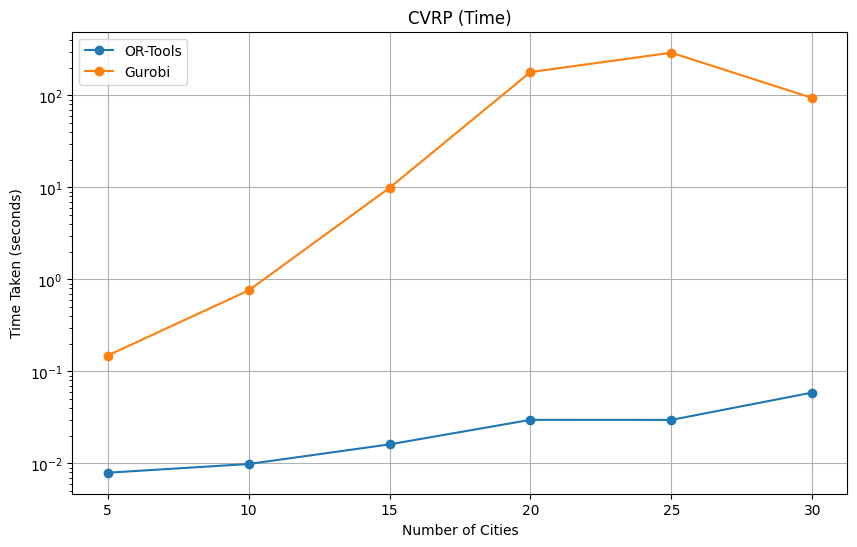

In [ ]:
# Plot Results
plt.figure(figsize=(10, 6))
# plt.plot(sizes, time_pulp, label="PuLP - Time", marker="o")
plt.plot(sizes, times_o, label="OR-Tools", marker="o")
plt.plot(sizes, times_g, label="Gurobi", marker="o")
plt.xlabel("Number of Cities")
plt.ylabel("Time Taken (seconds)")
plt.title("CVRP (Time)")
plt.yscale('log')  # Log scale if execution times vary widely
plt.legend()

plt.grid()
plt.show()


In [ ]:
import itertools

def solve_cvrp(distances, demands, vehicle_capacity, num_vehicles):
    """
    Solve Capacitated Vehicle Routing Problem

    :param distances: 2D matrix of distances between nodes
    :param demands: Demand for each node (including depot)
    :param vehicle_capacity: Maximum capacity per vehicle
    :param num_vehicles: Number of available vehicles
    :return: Optimal routes and total distance
    """
    num_nodes = len(distances)

    # Track best solution
    best_routes = None
    min_total_distance = float('inf')

    # Generate all possible customer permutations
    for perm in itertools.permutations(range(1, num_nodes)):
        # Initialize routes and tracking variables
        routes = [[] for _ in range(num_vehicles)]
        total_distance = 0
        vehicle_loads = [0] * num_vehicles

        # Try to assign customers to vehicles
        current_vehicle = 0
        last_node = 0  # Start from depot

        for customer in perm:
            # Check if adding customer exceeds vehicle capacity
            if vehicle_loads[current_vehicle] + demands[customer] > vehicle_capacity:
                # Return to depot and switch vehicle
                total_distance += distances[last_node][0]
                last_node = 0
                current_vehicle += 1

                # Check if we've exceeded available vehicles
                if current_vehicle >= num_vehicles:
                    break

            # Add customer to current vehicle's route
            routes[current_vehicle].append(customer)
            total_distance += distances[last_node][customer]
            vehicle_loads[current_vehicle] += demands[customer]
            last_node = customer

        # Return final vehicle to depot
        total_distance += distances[last_node][0]

        # Update best solution if valid and better
        if (current_vehicle < num_vehicles and
            total_distance < min_total_distance):
            min_total_distance = total_distance
            best_routes = routes

    return best_routes, min_total_distance

# Example usage
def main():
    distances = d
    demands = demand  # Depot has demand 0
    vehicle_capacity = cap
    num_vehicles = 2
    start_time = time.time()
    best_routes, total_distance = solve_cvrp(distances, demands, vehicle_capacity, num_vehicles)
    t_p= time.time() - start_time
    print("Best Routes:", best_routes)
    print("Total Distance:", total_distance)

if __name__ == "__main__":
    main()

Best Routes: [[2, 3], [1, 4]]
Total Distance: 282


In [ ]:
t_p

0.501746654510498